In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn, sys
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import scipy
from scipy.linalg import lstsq
from copy import copy

In [2]:
# set style to ggplot
plt.style.use('ggplot')

## Version Numbers

In [3]:
libraries = (('Matplotlib', matplotlib), ('Numpy', np), 
             ('Pandas', pd), ('Scipy', scipy), ('Sklearn', sklearn))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.5.4 |Anaconda custom (x86_64)| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.13.1
Pandas Version: 0.20.3
Scipy Version: 0.19.1
Sklearn Version: 0.19.0


---

## Generate Data

In [4]:
np.random.seed(10)
X = np.arange(10)
X_wbias = np.c_[np.ones(X.shape[0]), X]
y = [np.dot(x, 2) + np.random.normal(loc=0, scale=1.25) for x in X]

---

## View Data

In [5]:
X

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
X_wbias

array([[ 1.,  0.],
       [ 1.,  1.],
       [ 1.,  2.],
       [ 1.,  3.],
       [ 1.,  4.],
       [ 1.,  5.],
       [ 1.,  6.],
       [ 1.,  7.],
       [ 1.,  8.],
       [ 1.,  9.]])

In [7]:
y

[1.6644831301618976,
 2.8940987179980069,
 2.0682496348609147,
 5.9895201875893473,
 8.7766699673630999,
 9.0998930491013788,
 12.33188948211515,
 14.135685657143712,
 16.00536428866754,
 17.781749736758822]

In [8]:
print('dimensionality of features:', X.shape)
print('dimensionality of target:', (len(y),))

dimensionality of features: (10,)
dimensionality of target: (10,)


In [9]:
X_wbias.shape

(10, 2)

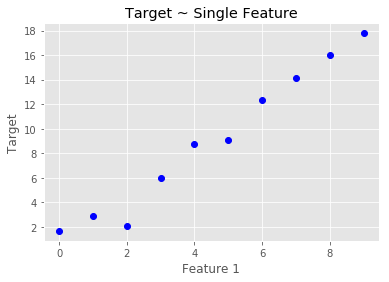

In [10]:
plt.plot(X, y, 'bo');
plt.title('Target ~ Single Feature')
plt.xlabel('Feature 1')
plt.ylabel('Target');

---

## 1. Sklearn

In [11]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
lr.intercept_

0.44234848888175193

In [13]:
lr.coef_

array([ 1.91831375])

In [14]:
sklearn_coef = np.array([lr.intercept_, lr.coef_])
sklearn_coef

array([ 0.44234849,  1.91831375])

---

## 2. Scipy Least Squares Solution

In [15]:
sp_coef, residue, rank, s = lstsq(X_wbias, y)
sp_coef

array([ 0.44234849,  1.91831375])

---

## 3. Coefficients w/Linear Algebra
The closed form solution for finding linear regression coefficients: $\hat{\theta}$ = ($X^TX)^{-1}X^TY$

In [16]:
xtx = np.dot(X_wbias.T, X_wbias)
inv_xtx = np.linalg.inv(xtx)
xty = np.dot(X_wbias.T, y)

In [17]:
la_coef = np.dot(inv_xtx, xty)
la_coef

array([ 0.44234849,  1.91831375])

---

## 4. Coefficients w/Gradient Descent

In [18]:
class BatchGradientDescent:
        
    def __init__(self, alpha=0.001, n_iter=20, seed=None):
        self.alpha_ = alpha
        self.n_iter_ = n_iter
        self.seed_ = seed

    def fit(self, X, y):
        '''run gradient descent on training data'''
        if self.seed_:
            np.random.seed(self.seed_)
        # randomly initialize coefficients
        self._initial_coef = np.random.randn(1 + X.shape[1])  
        self.coef_ = copy(self._initial_coef) 
        self.cost_ = []
        
        for i in range(self.n_iter_):
            output = self.predict(X)
            residuals = (output - y)
            self.coef_[1:] -= self.alpha_ * X.T.dot(residuals)
            self.coef_[0] -= self.alpha_ * residuals.sum()
            cost = (residuals**2).sum() / 2.
            self.cost_.append(cost)
    
    def predict(self, X):
        '''return predictions for given inputs'''
        return np.dot(X, self.coef_[1:]) + self.coef_[0]

In [19]:
def plot(X, y, obj, initial=None):
    '''plot actual vs predicted values'''
    plt.plot(X, y, 'bo', label='actual')
    plt.xlabel('X')
    plt.ylabel('y')
    if initial:
        plt.plot(X, np.dot(X.reshape(-1,1), gd._initial_coef[1:]) + gd._initial_coef[0], 
                 color='darkorange', 
                 label='predicted')
        plt.title('Before GD');
    else:
        plt.title('After GD')
        plt.plot(X, gd.predict(X.reshape(-1,1)), color='darkorange', label='predicted');
    plt.legend()

In [20]:
def cost_plot(obj):
    '''plot cost as a function of iteration number'''
    plt.plot(obj.cost_);
    plt.title('Cost vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Cost');

In [21]:
gd = BatchGradientDescent(alpha=0.001, n_iter=30, seed=43)
gd.fit(X.reshape(-1,1), y)

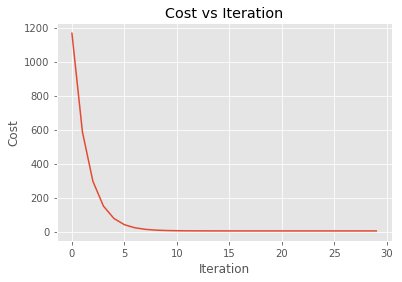

In [22]:
cost_plot(gd)

In [23]:
gd._initial_coef

array([ 0.25739993, -0.90848143])

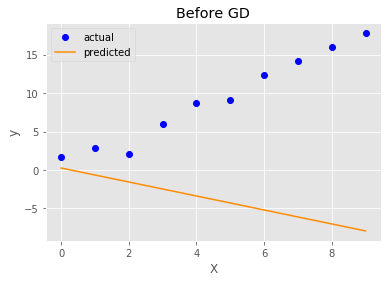

In [24]:
plot(X.reshape(-1,1), y, gd, initial=1)

In [25]:
gd.coef_

array([ 0.68050901,  1.88024331])

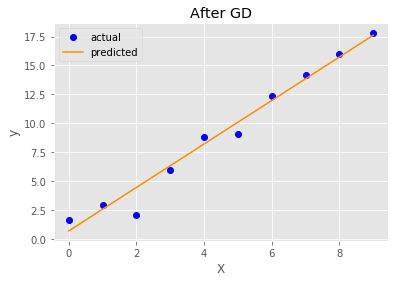

In [26]:
plot(X.reshape(-1,1), y, gd, initial=None)

---

## Side-by-Side

In [27]:
# Compare Scratch & Sklearn coefficients
import pandas as pd
pd.DataFrame(data=np.matrix([la_coef, sp_coef, sklearn_coef, gd.coef_]).reshape(4, 2).T, 
             index = ['theta0', 'theta1'],
             columns=['analytic', 'scipy', 'sklearn', 'grad desc'])

,analytic,scipy,sklearn,grad desc
theta0,0.442348,0.442348,0.442348,0.680509
theta1,1.918314,1.918314,1.918314,1.880243


---

## Now Let's Try Multivariate Data

In [28]:
# load data from sklearn
boston = load_boston()
data = boston.data
target = boston.target

In [29]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [30]:
# standard scale data for faster GD convergence
ss = StandardScaler()
std_data = ss.fit_transform(data)

In [31]:
bgd = BatchGradientDescent(alpha=0.0001, n_iter=50, seed=199)
bgd.fit(std_data, target)

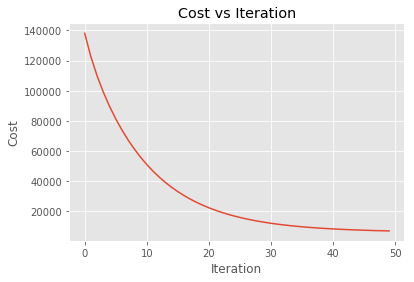

In [32]:
cost_plot(bgd);

## Compare Closed Form & Gradient Descent Coefficient Estimates

In [33]:
closed_form = lstsq(np.c_[np.ones(std_data.shape[0]), std_data], target)[0]
closed_form = np.round(closed_form, 2)
print('Coef |  GD   | CF')
print('-----|-------|----')
for i, (gd_coef, cf_coef) in enumerate(zip(np.round(bgd.coef_, 2), closed_form)):
    print('{0:4} | {1:5} | {2}'.format(i, gd_coef, cf_coef))

Coef |  GD   | CF
-----|-------|----
   0 | 20.94 | 22.53
   1 | -1.01 | -0.92
   2 |  0.79 | 1.08
   3 | -1.54 | 0.14
   4 |  0.72 | 0.68
   5 | -0.33 | -2.06
   6 |  3.65 | 2.67
   7 | -0.63 | 0.02
   8 | -2.25 | -3.1
   9 |  0.19 | 2.66
  10 |  0.52 | -2.08
  11 | -1.92 | -2.06
  12 |  1.23 | 0.86
  13 | -1.95 | -3.75
